## Imports

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from skimage import io, transform
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
warnings.filterwarnings("ignore")

plt.ion() 

## Pre-process data

In [2]:
train_path = './data/cars_train/'
test_path = './data/cars_test/'
devkit_path = './data/cars_devkit'

train_annos_path = devkit_path + '/cars_train_annos.csv'
test_annos_path = devkit_path + '/cars_test_annos.csv'
cars_meta_path = devkit_path + '/cars_meta.csv'

In [3]:
train_annos = pd.read_csv(train_annos_path, header=None)
test_annos = pd.read_csv(test_annos_path, header=None)
cars_meta = pd.read_csv(cars_meta_path, header=None)

train_annos.columns = ['file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'label']
test_annos.columns = ['file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'label']
cars_meta.columns = ['label_details']
train_annos['label'] = train_annos['label']-1
test_annos['label'] = test_annos['label']-1

In [4]:
def label_details(row):
    index = row['label']
    return cars_meta.loc[index, 'label_details']

train_annos['label_details'] = train_annos.apply(lambda row: label_details(row), axis=1)
test_annos['label_details'] = test_annos.apply(lambda row: label_details(row), axis=1)

In [5]:
def rgb_images(data_path, df):
    for i, row in df.iterrows():
        file = row['file']
        image = Image.open(data_path + file)
        num_channel = len(image.split())
        if (num_channel != 3):
            df.loc[i, 'rgb'] = False
        else:
            df.loc[i, 'rgb'] = True
    df = df[df.rgb == True]
    df = df.drop('rgb', axis=1)
    return df

train_annos = rgb_images(train_path, train_annos)
test_annos = rgb_images(test_path, test_annos)

## Save pre-processed data 

In [6]:
train_annos.to_csv('train_annos_cleaned.csv', index=False)
test_annos.to_csv('test_annos_cleaned.csv', index=False)

## Create dataloader

In [7]:
class CarsDataset(Dataset):

    def __init__(self, annos_path, data_dir, transform=None):
        """
        Args:
            annos_path (string): Path to the csv file with annotations.
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.car_details = pd.read_csv(annos_path)
        self.car_details = np.array(self.car_details)

        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.car_details)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.car_details[idx][0])
        image = Image.open(img_name)
        num_channel = len(image.split())
        car_class = self.car_details[idx][5]
        car_details = self.car_details[idx][6]
        x1, y1, x2, y2 = self.car_details[idx][1], self.car_details[idx][2], self.car_details[idx][3], self.car_details[idx][4]
        bounding_box = [x1, y1, x2, y2]

        if self.transform:
            image = self.transform(image)
     
        return image, bounding_box, car_class, car_details


## Visualize training data

In [8]:
train_annos.head()

,file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label,label_details
0,00001.jpg,39,116,569,375,13,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,2,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,90,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,133,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,105,Ford F-450 Super Duty Crew Cab 2012


In [9]:
train_annos.describe(include='all')

,file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label,label_details
count,8126,8126.000000,8126.000000,8126.000000,8126.000000,8126.000000,8126
unique,8126,NaN,NaN,NaN,NaN,NaN,196
top,05135.jpg,NaN,NaN,NaN,NaN,NaN,GMC Savana Van 2012
freq,1,NaN,NaN,NaN,NaN,NaN,68
mean,NaN,64.955206,108.644721,638.257937,416.540364,98.106325,NaN
std,NaN,82.215563,104.591748,410.943033,273.889092,56.449929,NaN
min,NaN,1.000000,1.000000,76.000000,47.000000,0.000000,NaN
25%,NaN,19.000000,42.000000,392.000000,248.000000,50.000000,NaN
50%,NaN,39.000000,80.000000,569.000000,360.000000,98.000000,NaN
75%,NaN,79.000000,138.000000,746.000000,477.000000,147.000000,NaN


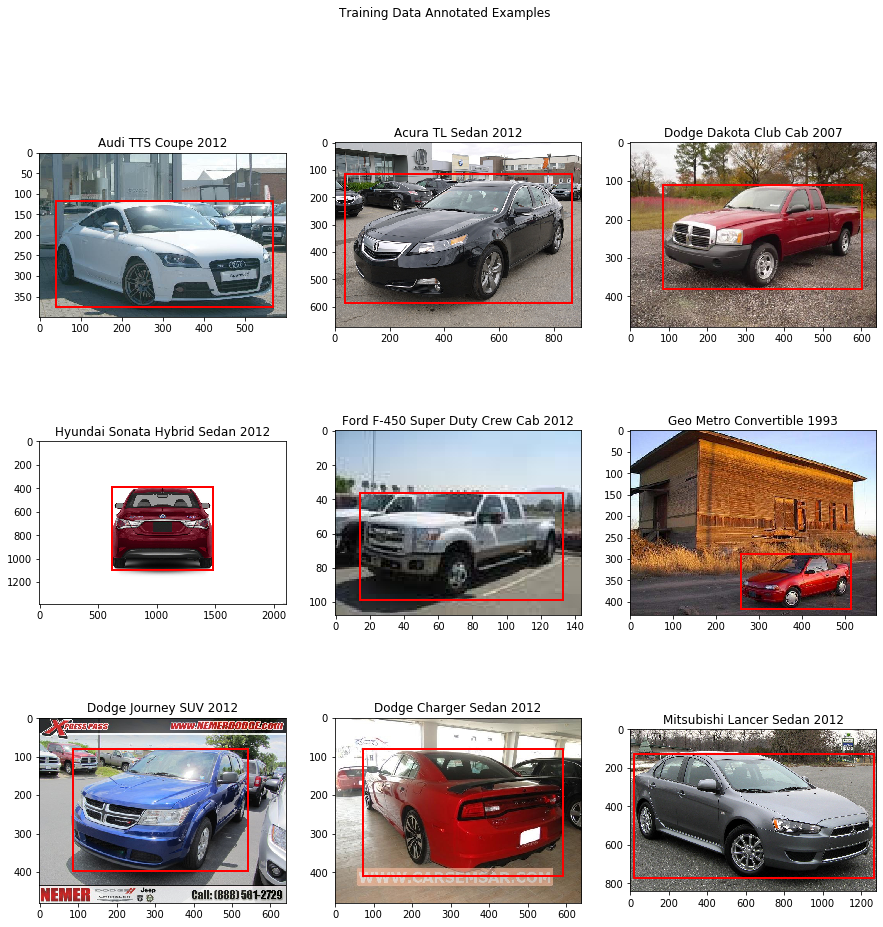

In [10]:
cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path)

fig, axs = plt.subplots(3, 3, figsize=(15,15)) 
idx = 0
for i in range(3):
    for j in range(3):
        sample = cars_data_train[idx][0]
        box = cars_data_train[idx][1]
        title = cars_data_train[idx][3]

        xy = box[0], box[1]
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
        
        axs[i, j].imshow(sample)
        axs[i, j].set_title(title)
        axs[i, j].add_patch(rect)
        idx += 1
        
fig.suptitle("Training Data Annotated Examples")
plt.savefig("training_annotations_examples.png")

## Data distribution

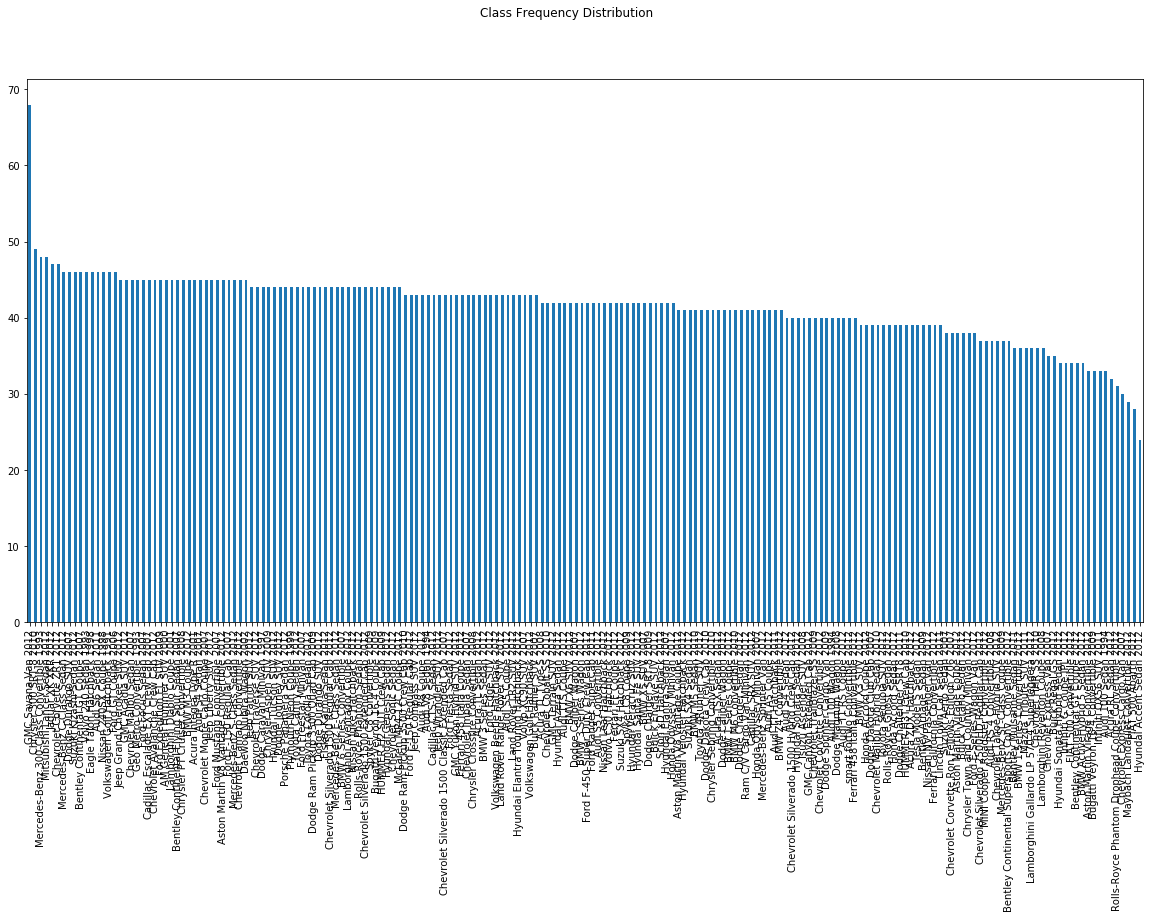

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
dataset = pd.read_csv('train_annos_cleaned.csv')
dataset['label_details'].value_counts().plot(ax=ax, kind='bar')

fig.suptitle("Class Frequency Distribution")
plt.savefig("class_frequency_distribution.png")

## Set up the ResNet model

In [12]:
def train_valid_split(train_dataset):
    np.random.random(2020)
    indices = list(range(len(train_dataset)))
    np.random.shuffle(indices)
    
    subset_indices_train = indices[: int(0.85*len(train_dataset))]
    subset_indices_valid = indices[int(0.85*len(train_dataset)) :]

    assert (len(subset_indices_train) + len(subset_indices_valid) == len(train_dataset))
    return subset_indices_train, subset_indices_valid

cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path, transform=transforms.Compose(
    [transforms.Resize(100), transforms.RandomSizedCrop(100), transforms.ToTensor()]))

subset_indices_train, subset_indices_valid = train_valid_split(cars_data_train)

train_loader = torch.utils.data.DataLoader(cars_data_train, batch_size=64, sampler=SubsetRandomSampler(subset_indices_train))
val_loader = torch.utils.data.DataLoader(cars_data_train, batch_size=64, sampler=SubsetRandomSampler(subset_indices_valid))

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')

In [19]:
def train_model(model, criterion, optimizer, scheduler, n_epochs):
    model.train()
    all_losses = []
    all_accuracies = []
    for epoch in range(n_epochs):
        losses = []
        correct = 0
        for i, data in enumerate(train_loader, 0):
            inputs, bbox, labels, details = data
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            correct += (labels==predicted).sum().item() 
        accuracy = 100/64*correct/len(train_loader)
        print("Epoch %s, Training Accuracy: %.4f %%, Training Loss: %.4f" % (epoch+1, accuracy, np.average(losses)))
        all_losses.append(np.average(losses))
        all_accuracies.append(accuracy)
    return all_losses, all_accuracies
   
def test_model(model, val_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, bbox, labels, details = data
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    print('Validation accuracy: %.4f %%' % (test_acc))
    return test_acc


## Run the model

In [20]:
training_losses, training_accuracies = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)
test_accuracy = test_model(model_ft, val_loader)

Epoch 1, Training Accuracy: 36.1400 %, Training Loss: 2.5699
Epoch 2, Training Accuracy: 42.2020 %, Training Loss: 2.3147
Epoch 3, Training Accuracy: 46.0069 %, Training Loss: 2.1402
Epoch 4, Training Accuracy: 49.0596 %, Training Loss: 1.9670
Epoch 5, Training Accuracy: 53.8050 %, Training Loss: 1.8113
Epoch 6, Training Accuracy: 55.9751 %, Training Loss: 1.6922
Epoch 7, Training Accuracy: 57.6678 %, Training Loss: 1.5975
Epoch 8, Training Accuracy: 60.1707 %, Training Loss: 1.5120
Epoch 9, Training Accuracy: 62.8762 %, Training Loss: 1.4161
Epoch 10, Training Accuracy: 65.0174 %, Training Loss: 1.3434
Validation accuracy: 37.5718 %


In [22]:
# we'll fix this, but yikes ^

In [23]:
torch.save(model_ft.state_dict(), "initial_resnet.pt")

## Visualize the model's predictions

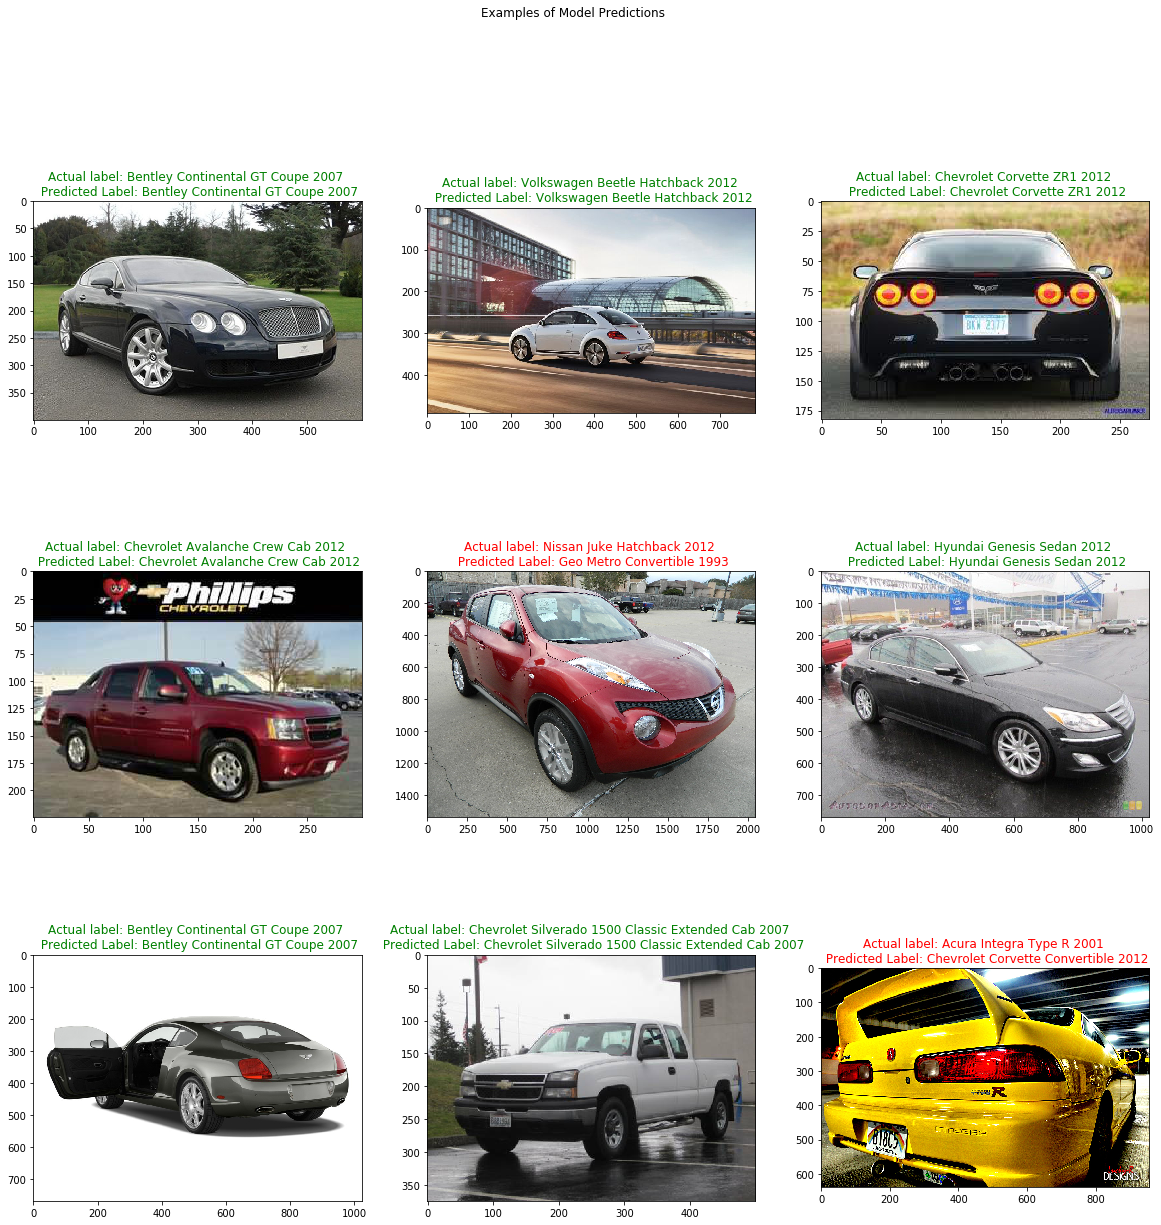

In [53]:
cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path)
cars_meta = pd.read_csv(cars_meta_path, header=None)

transform = transforms.Compose([transforms.Resize(100), transforms.RandomSizedCrop(100), transforms.ToTensor()])

fig, axs = plt.subplots(3, 3, figsize=(20,20)) 
idx = 100
for i in range(3):
    for j in range(3):
        image = cars_data_train[idx][0]
        sample = image
        actual = cars_data_train[idx][3]
        sample = transform(sample)
        sample = torch.autograd.Variable(sample)
        sample = sample.unsqueeze(0)
        output = model_ft(sample)
        conf, pred = torch.max(output.data, 1)
        pred = pred.item()
        pred = cars_meta.loc[pred, 0]
        axs[i, j].imshow(image)
        if (pred == actual):
            c = 'g'
        else:
            c = 'r'
        axs[i, j].set_title('Actual label: {} \n Predicted Label: {}'.format(actual, pred), fontdict = {'color': c})
        idx += 1

        
fig.suptitle("Examples of Model Predictions")
plt.savefig("model_predictions1.png")